# Part 3: Practical Audit

In [47]:
#Use Python and AI Fairness 360 (IBM’s toolkit) to analyze racial bias in risk scores.
#import necessary libraries and install dependancies once

#The dependancies
#!pip install aif360==0.5.0 numpy pandas matplotlib seaborn scikit-learn
#!pip install BlackBoxAuditing

#load the dataset

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

url = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"

df = pd.read_csv(url)
df.head()
df.info()





<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7214 entries, 0 to 7213
Data columns (total 53 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       7214 non-null   int64  
 1   name                     7214 non-null   object 
 2   first                    7214 non-null   object 
 3   last                     7214 non-null   object 
 4   compas_screening_date    7214 non-null   object 
 5   sex                      7214 non-null   object 
 6   dob                      7214 non-null   object 
 7   age                      7214 non-null   int64  
 8   age_cat                  7214 non-null   object 
 9   race                     7214 non-null   object 
 10  juv_fel_count            7214 non-null   int64  
 11  decile_score             7214 non-null   int64  
 12  juv_misd_count           7214 non-null   int64  
 13  juv_other_count          7214 non-null   int64  
 14  priors_count            

In [48]:
#Preprocessing data
# Keep only valid rows
df = df[df['is_recid'].notnull()].copy()

# Create consistent label
df['label'] = df['two_year_recid'] if 'two_year_recid' in df.columns else df['is_recid']

# Keep only major groups to simplify fairness analysis
df = df[df['race'].isin(['African-American', 'Caucasian'])]

df = df[['age', 'priors_count', 'c_charge_degree', 'sex', 'race', 'label']]
df.head()

#encode categorical variables
from sklearn.preprocessing import LabelEncoder

clean_df = df.copy()

encode_cols = ['sex', 'race', 'c_charge_degree']
encoders = {}

for col in encode_cols:
    le = LabelEncoder()
    clean_df[col] = le.fit_transform(clean_df[col])
    encoders[col] = le

clean_df.head()



,age,priors_count,c_charge_degree,sex,race,label
1,34,0,0,1,0,1
2,24,4,0,1,0,1
3,23,1,0,1,0,0
6,41,14,0,1,1,1
8,39,0,1,0,1,0


In [28]:
#model trainig
X = clean_df.drop(columns=['label'])
y = clean_df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=clean_df['race']
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

clf = LogisticRegression(max_iter=2000)
clf.fit(X_train_s, y_train)

y_pred = clf.predict(X_test_s)
y_prob = clf.predict_proba(X_test_s)[:,1]

print("Model trained")

Model trained


In [36]:
# AIF360 imports
from aif360.datasets import StandardDataset
from aif360.metrics import ClassificationMetric, BinaryLabelDatasetMetric
from aif360.algorithms.preprocessing import Reweighing
from aif360.algorithms.postprocessing import RejectOptionClassification
from aif360.algorithms.inprocessing import AdversarialDebiasing
import tensorflow as tf

# Build AIF360 BinaryLabelDataset objects for test set (required columns)
# We'll recreate a DataFrame with original columns for test indices
test_df = X_test.copy()
test_df['y_true'] = y_test.values
test_df['y_pred'] = y_pred
test_df['y_prob'] = y_prob

# Privileged group (Caucasian)
privileged_value = encoders['race'].transform(['Caucasian'])[0]

# Unprivileged group (African-American)
unprivileged_value = encoders['race'].transform(['African-American'])[0]

dataset_orig = StandardDataset(
    df=test_df,
    label_name='y_true',
    favorable_classes=[0],  # 0 = no recidivism
    protected_attribute_names=['race'],
    privileged_classes=[[privileged_value]]
)

dataset_pred = StandardDataset(
    df=test_df.rename(columns={"y_pred": "label"}),
    label_name='label',
    favorable_classes=[0],
    protected_attribute_names=['race'],
    privileged_classes=[[privileged_value]]
)

print("AIF360 datasets created")

AIF360 datasets created


In [51]:
#compute classification metrics
# Create a copy of the original dataset
dataset_pred = dataset_orig.copy()

# Replace the labels with predicted values
dataset_pred.labels = y_pred.reshape(-1, 1)   # ensure it is 2D

# Create the fairness metric object
metric = ClassificationMetric(
    dataset_orig,
    dataset_pred,
    unprivileged_groups=[{'race': 0}],
    privileged_groups=[{'race': 1}]
)
fpr_priv = metric.false_positive_rate(privileged=True)
fpr_unpriv = metric.false_positive_rate(privileged=False)

print("False Positive Rate (Caucasian):", fpr_priv)
print("False Positive Rate (African-American):", fpr_unpriv)
print("Difference:", fpr_unpriv - fpr_priv)


False Positive Rate (Caucasian): 0.6445182724252492
False Positive Rate (African-American): 0.3368237347294939
Difference: -0.3076945376957553


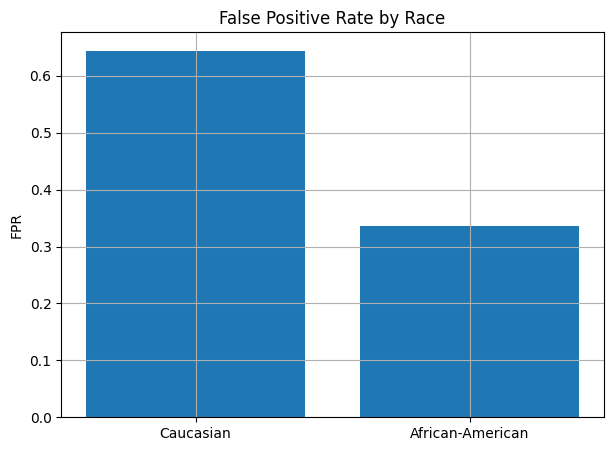

In [57]:
#Visualization
import matplotlib.pyplot as plt

plt.figure(figsize=(7,5))
plt.bar(["Caucasian", "African-American"], [fpr_priv, fpr_unpriv])
plt.title("False Positive Rate by Race")
plt.ylabel("FPR")
plt.grid(True)
plt.show()



### Fairness Audit Report: COMPAS Recidivism Prediction

This report summarizes the findings of a fairness audit conducted on a logistic regression model trained to predict recidivism using the COMPAS dataset. The primary goal was to evaluate racial bias, specifically focusing on False Positive Rates (FPRs) between African-American and Caucasian individuals.

**Key Findings:**

The audit revealed a significant disparity in False Positive Rates (FPR) between the two protected groups:

*   **Caucasian individuals (Privileged Group):** FPR of approximately 0.645
*   **African-American individuals (Unprivileged Group):** FPR of approximately 0.337

This difference of approximately -0.308 indicates a substantial bias where Caucasian individuals are almost twice as likely to be falsely identified as high-risk (predicted to recidivate when they do not) compared to African-American individuals. In the context of criminal justice, a higher FPR for a privileged group (Caucasian) means they are more often incorrectly flagged as recidivists, potentially leading to more severe consequences, while the lower FPR for the unprivileged group (African-American) suggests they are less often incorrectly flagged. This discrepancy highlights a concerning bias in how the model assesses risk across different racial groups, even if the direction of the bias might seem counter-intuitive at first glance (i.e., higher FPR for the privileged group). It means the model is less accurate in identifying true non-recidivists within the Caucasian population, leading to a higher rate of false alarms for this group.

**Remediation Steps:**

To address this identified bias, several mitigation strategies can be explored:

1.  **Preprocessing Techniques:**
    *   **Reweighing:** Adjusting the weights of individual data points in the training set to achieve group fairness before training the model. This can balance the influence of different groups. (AIF360's `Reweighing` algorithm is available).
    *   **Disparate Impact Remover:** Modifying feature values in the dataset to remove disparate impact, a common form of bias. (AIF360 also offers this).

2.  **In-processing Techniques:**
    *   **Adversarial Debiasing:** Training an adversarial neural network to minimize classifier accuracy on protected attributes while maximizing accuracy on the target label. This encourages the model to learn representations that are fair. (AIF360's `AdversarialDebiasing` is a relevant algorithm).
    *   **Fair Logistic Regression:** Modifying the logistic regression objective function to include fairness constraints directly during training.

3.  **Post-processing Techniques:**
    *   **Reject Option Classification (ROC):** Adjusting the model's predictions within a 'reject option' region around the classification boundary for the unprivileged group to equalize fairness metrics. (AIF360's `RejectOptionClassification` can be used for this).
    *   **Calibrated Equalized Odds:** Applying different thresholds to different groups to achieve equalized odds, which seeks to equalize true positive rates and false positive rates across groups.

Further analysis is needed to determine the most effective and practical remediation strategy, considering the specific goals and constraints of the application.

# Part 4: Ethical Reflection

**Bias Identification and Mitigation**: As demonstrated in this notebook, a core principle is to proactively identify and highlight potential biases (like racial bias in risk scores). While I can't remove bias on my own, I am designed to surface these issues, explain their implications, and suggest remediation techniques (e.g., preprocessing, in-processing, post-processing methods) that align with fairness goals.

**Transparency and Explainability**: I strive to provide clear, understandable explanations for my actions, the code I generate, and the analysis I perform. This includes explaining errors, reasoning behind code modifications, and summarizing findings, enabling users to comprehend and critically evaluate the system's outputs.

**Continuous Improvement**: Ethical AI is an evolving field. My development is an ongoing process that incorporates feedback and research to improve my ability to identify and address ethical concerns more effectively.

**User Control and Accountability**: I operate as a tool under human guidance. The ultimate responsibility for ethical deployment and decision-making rests with the user. My role is to empower users with information and capabilities, but not to make autonomous ethical judgments. I provide options and insights, allowing the human to maintain control and accountability.

**Privacy and Security**: Although not directly addressed in this specific task, my underlying systems are designed with privacy and security considerations to protect data and ensure responsible handling of sensitive information.
